In [ ]:
!pip install requests fuzzywuzzy
import nltk 
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import re
import pandas as pd
import numpy as np

from nltk.stem import WordNetLemmatizer, PorterStemmer
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import gensim

import pickle as cPickle
from fuzzywuzzy import fuzz
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from google.colab import drive

tqdm.pandas()
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/thesis/dataset_building/dataset_DIY.tsv', sep='\\t' , engine="python", encoding= 'unicode_escape')

In [ ]:
df.head()

,id,q1_id,q2_id,q1,c1,q2,c2,annotation
0,0,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/124266...,"""I have a Champion 120V generator, I want to u...","""I have a new champion generator, 120volt at 2...","""I have a 120/240 dryer from Canada, and want ...","""The dryer electric driagram identifies a RED...",1
1,1,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/153176...,"""I have a Champion 120V generator, I want to u...","""I have a new champion generator, 120volt at 2...",Powering 220V-to-neutral appliance from 120V s...,"""I have a 5kW appliance that normally accepts ...",1
2,2,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/202610...,"""I have a Champion 120V generator, I want to u...","""I have a new champion generator, 120volt at 2...",Is it possible to wire a 240v outlet so that a...,"""I'm in the US. I will be installing a 240v ou...",1
3,3,https://diy.stackexchange.com/questions/204189...,https://diy.stackexchange.com/questions/47210/...,Can I run conduit containing 120V wires inside...,"""I was wondering if I could run 120v wires ins...",Is there an advantage to using EMT over Plasti...,"""I am planning a structured wiring project. As...",0
4,4,https://diy.stackexchange.com/questions/204189...,https://diy.stackexchange.com/questions/63235/...,Can I run conduit containing 120V wires inside...,"""I was wondering if I could run 120v wires ins...",Which cable/conduit should I use to run a new ...,"""I'm in the middle of a kitchen remodel and ha...",1


In [ ]:
df.shape

(8299, 8)

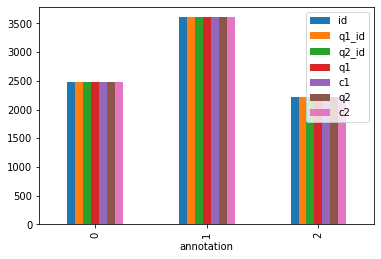

In [ ]:
df.groupby('annotation').count().plot.bar()

#Preprocessing

In [ ]:
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    x = re.sub(r'\W', ' ', str(x))
    
    x = re.sub(r"\s+", ' ', str(x))
    
    x = ' '.join(PorterStemmer().stem(word) for word in x.split())

    x = ' '.join(WordNetLemmatizer().lemmatize(word) for word in x.split())
    
    soup = BeautifulSoup(str(x))
    x = soup.get_text()

    x = ' '.join([word for word in x.split() if word not in stop_words])
    
    return x

In [ ]:
df['q1_clean'] = df['q1'].progress_apply(preprocess)
df['q2_clean'] = df['q2'].progress_apply(preprocess)

100%|██████████| 8299/8299 [00:06<00:00, 1380.11it/s]


#Feature Engieering

##Basic Feature Engineering (fr-1)

In [ ]:
df['len_q1'] = df.q1_clean.apply(lambda x: len(str(x)))
df['len_q2'] = df.q2_clean.apply(lambda x: len(str(x)))
df['diff_len'] = df.len_q1 - df.len_q2
df['len_char_q1'] = df.q1_clean.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
df['len_char_q2'] = df.q2_clean.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
df['len_word_q1'] = df.q1_clean.apply(lambda x: len(str(x).split()))
df['len_word_q2'] = df.q2_clean.apply(lambda x: len(str(x).split()))
df['common_words'] = df.apply(lambda x: len(set(str(x['q1_clean']).lower().split()).intersection(set(str(x['q2_clean']).lower().split()))), axis=1)

In [ ]:
df.head()

,id,q1_id,q2_id,q1,c1,q2,c2,annotation,q1_clean,q2_clean,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words
0,0,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/124266...,"""I have a Champion 120V generator, I want to u...","""I have a new champion generator, 120volt at 2...","""I have a 120/240 dryer from Canada, and want ...","""The dryer electric driagram identifies a RED...",1,champion 120v gener want use plug preinstal wi...,120 240 dryer canada want use 240v countri,75,42,33,21,18,12,8,2
1,1,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/153176...,"""I have a Champion 120V generator, I want to u...","""I have a new champion generator, 120volt at 2...",Powering 220V-to-neutral appliance from 120V s...,"""I have a 5kW appliance that normally accepts ...",1,champion 120v gener want use plug preinstal wi...,power 220v neutral applianc 120v split phase,75,44,31,21,18,12,7,3
2,2,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/202610...,"""I have a Champion 120V generator, I want to u...","""I have a new champion generator, 120volt at 2...",Is it possible to wire a 240v outlet so that a...,"""I'm in the US. I will be installing a 240v ou...",1,champion 120v gener want use plug preinstal wi...,possibl wire 240v outlet need 240v anymor two ...,75,58,17,21,22,12,10,3
3,3,https://diy.stackexchange.com/questions/204189...,https://diy.stackexchange.com/questions/47210/...,Can I run conduit containing 120V wires inside...,"""I was wondering if I could run 120v wires ins...",Is there an advantage to using EMT over Plasti...,"""I am planning a structured wiring project. As...",0,run conduit contain 120v wire insid larger con...,advantag use emt plastic flexibl conduit low v...,60,55,5,19,20,10,9,2
4,4,https://diy.stackexchange.com/questions/204189...,https://diy.stackexchange.com/questions/63235/...,Can I run conduit containing 120V wires inside...,"""I was wondering if I could run 120v wires ins...",Which cable/conduit should I use to run a new ...,"""I'm in the middle of a kitchen remodel and ha...",1,run conduit contain 120v wire insid larger con...,cabl conduit use run new 240 volt line oven,60,43,17,19,18,10,9,2


In [ ]:
max(df["len_word_q2"])

22

In [ ]:
df["leng"] = " "
for i in range(len(df)):
  a=df["len_word_q1"][i]
  b=df["len_word_q2"][i]
  df["leng"][i]= max(a,b)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
j=0
for i in range(len(df["leng"])):
  if df["leng"][i] < 10:
    j+=1

print(j)

6413


##FuzzyWuzzy Features (fr-2)


In [ ]:
df['fuzz_qratio'] = df.apply(lambda x: fuzz.QRatio(str(x['q1_clean']), str(x['q2_clean'])), axis=1)
df['fuzz_WRatio'] = df.apply(lambda x: fuzz.WRatio(str(x['q1_clean']), str(x['q2_clean'])), axis=1)
df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(str(x['q1_clean']), str(x['q2_clean'])), axis=1)
df['fuzz_partial_token_set_ratio'] = df.apply(lambda x: fuzz.partial_token_set_ratio(str(x['q1_clean']), str(x['q2_clean'])), axis=1)
df['fuzz_partial_token_sort_ratio'] = df.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['q1_clean']), str(x['q2_clean'])), axis=1)
df['fuzz_token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(str(x['q1_clean']), str(x['q2_clean'])), axis=1)
df['fuzz_token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(str(x['q1_clean']), str(x['q2_clean'])), axis=1)

In [ ]:
df.head()

,id,q1_id,q2_id,q1,c1,q2,c2,annotation,q1_clean,q2_clean,...,len_word_q2,common_words,leng,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,0,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/124266...,"""I have a Champion 120V generator, I want to u...","""I have a new champion generator, 120volt at 2...","""I have a 120/240 dryer from Canada, and want ...","""The dryer electric driagram identifies a RED...",1,champion 120v gener want use plug preinstal wi...,120 240 dryer canada want use 240v countri,...,8,2,12,41,86,48,100,50,41,41
1,1,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/153176...,"""I have a Champion 120V generator, I want to u...","""I have a new champion generator, 120volt at 2...",Powering 220V-to-neutral appliance from 120V s...,"""I have a 5kW appliance that normally accepts ...",1,champion 120v gener want use plug preinstal wi...,power 220v neutral applianc 120v split phase,...,7,3,12,30,86,55,100,64,54,50
2,2,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/202610...,"""I have a Champion 120V generator, I want to u...","""I have a new champion generator, 120volt at 2...",Is it possible to wire a 240v outlet so that a...,"""I'm in the US. I will be installing a 240v ou...",1,champion 120v gener want use plug preinstal wi...,possibl wire 240v outlet need 240v anymor two ...,...,10,3,12,30,49,39,100,50,52,51
3,3,https://diy.stackexchange.com/questions/204189...,https://diy.stackexchange.com/questions/47210/...,Can I run conduit containing 120V wires inside...,"""I was wondering if I could run 120v wires ins...",Is there an advantage to using EMT over Plasti...,"""I am planning a structured wiring project. As...",0,run conduit contain 120v wire insid larger con...,advantag use emt plastic flexibl conduit low v...,...,9,2,10,24,39,40,100,46,41,40
4,4,https://diy.stackexchange.com/questions/204189...,https://diy.stackexchange.com/questions/63235/...,Can I run conduit containing 120V wires inside...,"""I was wondering if I could run 120v wires ins...",Which cable/conduit should I use to run a new ...,"""I'm in the middle of a kitchen remodel and ha...",1,run conduit contain 120v wire insid larger con...,cabl conduit use run new 240 volt line oven,...,9,2,10,39,53,43,100,44,56,49


##Word2vec Features (fr-4)

In [ ]:
def wmd(s1, s2):
    s1 = str(s1).lower().split()
    s2 = str(s2).lower().split()
    stop_words = stopwords.words('english')
    s1 = [w for w in s1 if w not in stop_words]
    s2 = [w for w in s2 if w not in stop_words]
    return model.wmdistance(s1, s2)


def norm_wmd(s1, s2):
    s1 = str(s1).lower().split()
    s2 = str(s2).lower().split()
    stop_words = stopwords.words('english')
    s1 = [w for w in s1 if w not in stop_words]
    s2 = [w for w in s2 if w not in stop_words]
    return norm_model.wmdistance(s1, s2)


def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(model[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    return v / np.sqrt((v ** 2).sum())

In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/GoogleNews-vectors-negative300.bin.gz', binary=True)
df['wmd'] = df.apply(lambda x: wmd(x['q1_clean'], x['q2_clean']), axis=1)

In [ ]:
norm_model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/GoogleNews-vectors-negative300.bin.gz', binary=True)
norm_model.init_sims(replace=True)
df['norm_wmd'] = df.apply(lambda x: norm_wmd(x['q1_clean'], x['q2_clean']), axis=1)

In [ ]:
q1_vectors = np.zeros((df.shape[0], 300))
error_count = 0

In [ ]:
for i, q in tqdm(enumerate(df.q1_clean.values)):
    q1_vectors[i, :] = sent2vec(q)

1416it [00:00, 4873.59it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
8299it [00:01, 4945.49it/s]


In [ ]:
q2_vectors  = np.zeros((df.shape[0], 300))
for i, q in tqdm(enumerate(df.q2_clean.values)):
    q2_vectors[i, :] = sent2vec(q)


478it [00:00, 4777.70it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
8299it [00:01, 4923.53it/s]


In [ ]:
print(df["q1_clean"][0])
print()
q1_vectors

champion 120v gener want use plug preinstal wire 240volt split phase outlet



array([[ 1.09544722e-02,  4.26885635e-02, -1.35283973e-02, ...,
        -5.72945252e-02, -5.08448146e-02, -8.46995317e-05],
       [ 1.09544722e-02,  4.26885635e-02, -1.35283973e-02, ...,
        -5.72945252e-02, -5.08448146e-02, -8.46995317e-05],
       [ 1.09544722e-02,  4.26885635e-02, -1.35283973e-02, ...,
        -5.72945252e-02, -5.08448146e-02, -8.46995317e-05],
       ...,
       [-3.34338658e-02,  9.23377350e-02,  2.42981464e-02, ...,
         1.01640867e-03,  4.89311069e-02, -8.10257047e-02],
       [ 2.01869346e-02,  3.72259058e-02,  2.16193404e-02, ...,
         9.02749039e-03, -8.09476078e-02, -2.22522654e-02],
       [ 2.07072608e-02,  1.04895361e-01, -3.95951495e-02, ...,
         3.00306431e-03, -2.83464435e-02,  1.89974867e-02]])

In [ ]:
df['w2v_q1']=list(q1_vectors)
df['w2v_q2']=list(q2_vectors)

In [ ]:
df['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(q1_vectors),
                                                          np.nan_to_num(q2_vectors))]

df['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(q1_vectors),
                                                          np.nan_to_num(q2_vectors))]

df['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(q1_vectors),
                                                          np.nan_to_num(q2_vectors))]

df['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(q1_vectors),
                                                          np.nan_to_num(q2_vectors))]

df['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(q1_vectors),
                                                          np.nan_to_num(q2_vectors))]

df['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(q1_vectors),
                                                          np.nan_to_num(q2_vectors))]

df['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(q1_vectors),
                                                          np.nan_to_num(q2_vectors))]

df['skew_q1vec'] = [skew(x) for x in np.nan_to_num(q1_vectors)]
df['skew_q2vec'] = [skew(x) for x in np.nan_to_num(q2_vectors)]
df['kur_q1vec'] = [kurtosis(x) for x in np.nan_to_num(q1_vectors)]
df['kur_q2vec'] = [kurtosis(x) for x in np.nan_to_num(q2_vectors)]

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [ ]:
df.head()

,id,q1_id,q2_id,q1,c1,q2,c2,annotation,q1_clean,q2_clean,...,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec
0,0,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/124266...,"""I have a Champion 120V generator, I want to u...","""I have a new champion generator, 120volt at 2...","""I have a 120/240 dryer from Canada, and want ...","""The dryer electric driagram identifies a RED...",1,champion 120v gener want use plug preinstal wi...,120 240 dryer canada want use 240v countri,...,14.834014,1.0,186.720157,1.054694,0.473043,0.633509,-0.009964,0.045190,-0.212979,0.006337
1,1,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/153176...,"""I have a Champion 120V generator, I want to u...","""I have a new champion generator, 120volt at 2...",Powering 220V-to-neutral appliance from 120V s...,"""I have a 5kW appliance that normally accepts ...",1,champion 120v gener want use plug preinstal wi...,power 220v neutral applianc 120v split phase,...,13.312744,1.0,172.553213,0.967553,0.435035,0.547804,-0.009964,-0.056722,-0.212979,0.034857
2,2,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/202610...,"""I have a Champion 120V generator, I want to u...","""I have a new champion generator, 120volt at 2...",Is it possible to wire a 240v outlet so that a...,"""I'm in the US. I will be installing a 240v ou...",1,champion 120v gener want use plug preinstal wi...,possibl wire 240v outlet need 240v anymor two ...,...,10.850739,1.0,154.464164,0.784314,0.354521,0.424943,-0.009964,0.042109,-0.212979,-0.185819
3,3,https://diy.stackexchange.com/questions/204189...,https://diy.stackexchange.com/questions/47210/...,Can I run conduit containing 120V wires inside...,"""I was wondering if I could run 120v wires ins...",Is there an advantage to using EMT over Plasti...,"""I am planning a structured wiring project. As...",0,run conduit contain 120v wire insid larger con...,advantag use emt plastic flexibl conduit low v...,...,11.107777,1.0,154.856869,0.797738,0.359054,0.446247,0.006818,0.008905,0.071095,-0.008704
4,4,https://diy.stackexchange.com/questions/204189...,https://diy.stackexchange.com/questions/63235/...,Can I run conduit containing 120V wires inside...,"""I was wondering if I could run 120v wires ins...",Which cable/conduit should I use to run a new ...,"""I'm in the middle of a kitchen remodel and ha...",1,run conduit contain 120v wire insid larger con...,cabl conduit use run new 240 volt line oven,...,12.654678,1.0,169.650473,0.911558,0.408274,0.526942,0.006818,-0.115753,0.071095,0.081160


In [ ]:
cPickle.dump(q1_vectors, open('/content/drive/My Drive/thesis/feature_engineering/vectorization/q1_w2v_lc.pkl', 'wb'), -1)
cPickle.dump(q2_vectors, open('/content/drive/My Drive/thesis/feature_engineering/vectorization/q2_w2v_lc.pkl', 'wb'), -1)

In [ ]:
df.to_csv('/content/drive/My Drive/thesis/feature_engineering/features_lc.tsv', sep = '\t', index=False)